In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("../data/personal_finance_expenses.csv")

In [3]:
# --- Feature engineering ---
expense_cols = [
    'Rent','Loan_Repayment','Insurance','Groceries','Transport','Eating_Out',
    'Entertainment','Utilities','Healthcare','Education','Miscellaneous'
]

df['total_expenses'] = df[expense_cols].sum(axis=1)
df['estimated_savings'] = df['Income'] - df['total_expenses']

print(df[['Income','total_expenses','estimated_savings',
          'Desired_Savings','Disposable_Income']].head(5))

# Target
y = df['Desired_Savings']

# Features (drop derived columns and target)
X = df.drop(['Desired_Savings'] + 
            [col for col in df.columns if 'Potential_Savings' in col], axis=1)

# One-hot encode categorical columns
categorical_cols = ['Occupation', 'City_Tier']
X = pd.get_dummies(X, columns=categorical_cols)

print("Features shape:", X.shape)
print("Target shape:", y.shape)


          Income  total_expenses  estimated_savings  Desired_Savings  \
0   44637.249636    33371.621929       11265.627707      6200.537192   
1   26858.596592    17181.777859        9676.818733      1923.176434   
2   50367.605084    36476.154459       13891.450624      7050.360422   
3  101455.600247    69837.646632       31617.953615     16694.965136   
4   24875.283548    18609.583016        6265.700532      1874.099434   

   Disposable_Income  
0       11265.627707  
1        9676.818733  
2       13891.450624  
3       31617.953615  
4        6265.700532  
Features shape: (20000, 25)
Target shape: (20000,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (16000, 25) (16000,)
Test set: (4000, 25) (4000,)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("RMSE:", rmse)
print("R^2 Score:", r2)


Mean Squared Error (MSE): 5357642.449578871
RMSE: 2314.6581712164048
R^2 Score: 0.9258359205859337


                       feature  coefficient    abs_coef
22            City_Tier_Tier_1   499.709149  499.709149
24            City_Tier_Tier_3  -472.689270  472.689270
14  Desired_Savings_Percentage   336.895841  336.895841
23            City_Tier_Tier_2   -27.019879   27.019879
2                   Dependents    18.001808   18.001808
20    Occupation_Self_Employed    17.326378   17.326378
19          Occupation_Retired   -13.450225   13.450225
21          Occupation_Student    -6.866465    6.866465
18     Occupation_Professional     2.990312    2.990312
1                          Age    -1.174060    1.174060
10                   Utilities     0.188490    0.188490
13               Miscellaneous    -0.164857    0.164857
6                    Groceries    -0.147401    0.147401
9                Entertainment     0.142434    0.142434
0                       Income     0.112892    0.112892


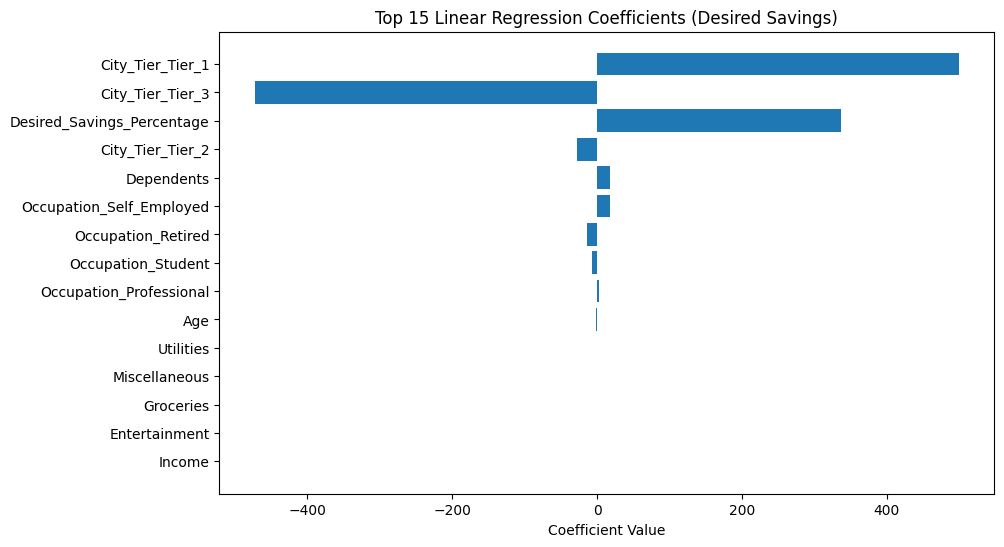

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names
feature_names = X_train.columns

# Pair coefficients with feature names
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": lr_model.coef_
})

# Sort by absolute impact
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values(by="abs_coef", ascending=False)

# Show top 15 in table
print(coef_df.head(15))

# Plot top 15
top_n = 15
plt.figure(figsize=(10,6))
plt.barh(coef_df["feature"].head(top_n), coef_df["coefficient"].head(top_n))
plt.xlabel("Coefficient Value")
plt.title(f"Top {top_n} Linear Regression Coefficients (Desired Savings)")
plt.gca().invert_yaxis()  # so biggest is at the top
plt.show()

In [7]:
from sklearn.metrics import mean_absolute_error
import pandas as pd

mae  = mean_absolute_error(y_test, y_pred)

summary = pd.DataFrame({
    "metric": ["MAE", "RMSE", "R^2"],
    "value":  [mae, rmse, r2]
})
print(summary)


  metric        value
0    MAE  1311.208594
1   RMSE  2314.658171
2    R^2     0.925836


In [8]:
import os, joblib

os.makedirs("../models", exist_ok=True)

joblib.dump(lr_model, "../models/savings_linear_reg.pkl")
joblib.dump(list(X_train.columns), "../models/savings_linear_reg_columns.pkl")

print("Saved model to ../models/savings_linear_reg.pkl")
print("Saved columns to ../models/savings_linear_reg_columns.pkl")


Saved model to ../models/savings_linear_reg.pkl
Saved columns to ../models/savings_linear_reg_columns.pkl


In [14]:
import joblib
import numpy as np
import pandas as pd

# --- Load model and columns ---
loaded_model = joblib.load("../models/savings_linear_reg.pkl")
loaded_columns = joblib.load("../models/savings_linear_reg_columns.pkl")

print("Model and schema loaded!")

# --- Make a sample input ---
# pick one row from your test set (convert to DataFrame with correct columns)
for i in [0, 1, 5, 10]:
    sample = X_test.iloc[i:i+1].copy()
    sample = sample.reindex(columns=loaded_columns, fill_value=0)
    pred = loaded_model.predict(sample)
    
    actual = y_test.iloc[i]
    error = pred[0] - actual
    pct_error = (error / actual) * 100 if actual != 0 else np.nan
    
    print(f"Row {i}")
    print(f"  Actual:    {actual:.2f}")
    print(f"  Predicted: {pred[0]:.2f}")
    print(f"  Error:     {error:.2f}  ({pct_error:.1f}%)\n")

Model and schema loaded!
Row 0
  Actual:    1577.91
  Predicted: 1641.43
  Error:     63.52  (4.0%)

Row 1
  Actual:    1972.33
  Predicted: 2077.45
  Error:     105.11  (5.3%)

Row 5
  Actual:    1202.87
  Predicted: 670.83
  Error:     -532.04  (-44.2%)

Row 10
  Actual:    947.16
  Predicted: -41.56
  Error:     -988.72  (-104.4%)



In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [23]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=600,          
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [24]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd

y_pred_xgb = xgb.predict(X_test)

mse_xgb  = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb   = r2_score(y_test, y_pred_xgb)
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)

comparison = pd.DataFrame({
    "metric": ["MAE", "RMSE", "R^2"],
    "Linear": [mae, rmse, r2],      # from your linear model earlier
    "XGBoost": [mae_xgb, rmse_xgb, r2_xgb]
})
print(comparison)


  metric       Linear      XGBoost
0    MAE  1311.208594   147.837080
1   RMSE  2314.658171  2648.443343
2    R^2     0.925836     0.902904


In [29]:
import os, joblib

os.makedirs("../models", exist_ok=True)

joblib.dump(xgb, "../models/savings_xgb_reg.pkl")
joblib.dump(list(X_train.columns), "../models/savings_xgb_reg_columns.pkl")

print("Saved XGBoost model to ../models/savings_xgb_reg.pkl")
print("Saved columns to ../models/savings_xgb_reg_columns.pkl")


Saved XGBoost model to ../models/savings_xgb_reg.pkl
Saved columns to ../models/savings_xgb_reg_columns.pkl


In [30]:
# Load back and predict a single test row to verify
xgb_loaded = joblib.load("../models/savings_xgb_reg.pkl")
xgb_cols   = joblib.load("../models/savings_xgb_reg_columns.pkl")

sample = X_test.iloc[0:1].reindex(columns=xgb_cols, fill_value=0)
print("XGBoost predicted:", xgb_loaded.predict(sample)[0], 
      "| actual:", y_test.iloc[0])


XGBoost predicted: 1599.6572 | actual: 1577.9140909748096


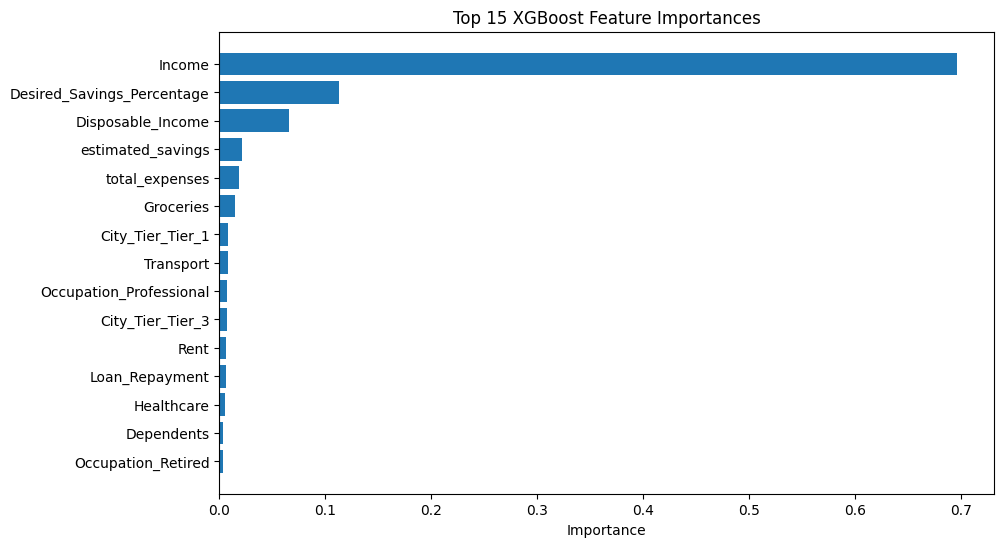

Income                        0.697034
Desired_Savings_Percentage    0.113132
Disposable_Income             0.066071
estimated_savings             0.021791
total_expenses                0.018110
Groceries                     0.014667
City_Tier_Tier_1              0.008138
Transport                     0.007950
Occupation_Professional       0.007226
City_Tier_Tier_3              0.007049
Rent                          0.006622
Loan_Repayment                0.006196
Healthcare                    0.005613
Dependents                    0.003583
Occupation_Retired            0.003094
dtype: float32


In [25]:
import matplotlib.pyplot as plt
import pandas as pd

imp = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)

top_n = 15
plt.figure(figsize=(10,6))
plt.barh(imp.head(top_n).index, imp.head(top_n).values)
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} XGBoost Feature Importances")
plt.xlabel("Importance")
plt.show()

print(imp.head(top_n))


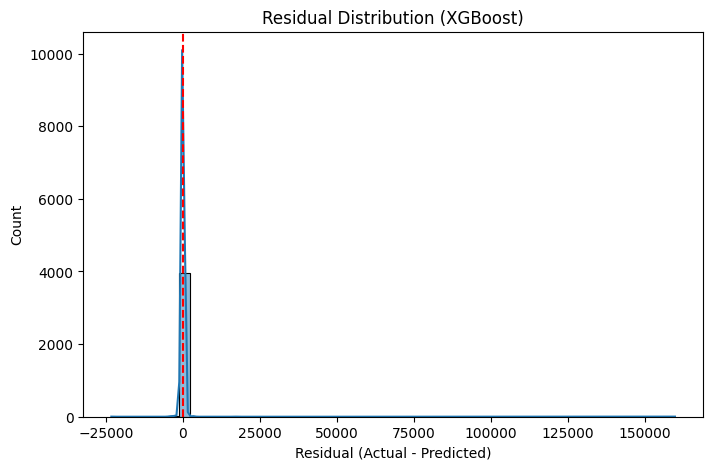

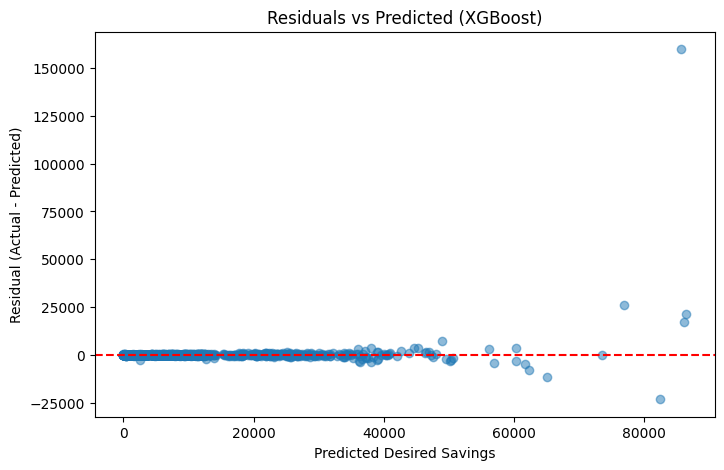

Residual mean: 41.25380497076635
Residual std: 2648.4531034191805
Min residual: -23233.164366739766
Max residual: 159846.11802092093


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residuals
residuals = y_test - y_pred_xgb

# 1) Histogram of residuals
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution (XGBoost)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()

# 2) Residuals vs Predicted
plt.figure(figsize=(8,5))
plt.scatter(y_pred_xgb, residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted (XGBoost)")
plt.xlabel("Predicted Desired Savings")
plt.ylabel("Residual (Actual - Predicted)")
plt.show()

# Quick summary stats
print("Residual mean:", residuals.mean())
print("Residual std:", residuals.std())
print("Min residual:", residuals.min())
print("Max residual:", residuals.max())


Residual mean: 52.031616961140735
Residual std: 2314.3625966932073
Min residual: -21207.486158408516
Max residual: 51889.742878765624


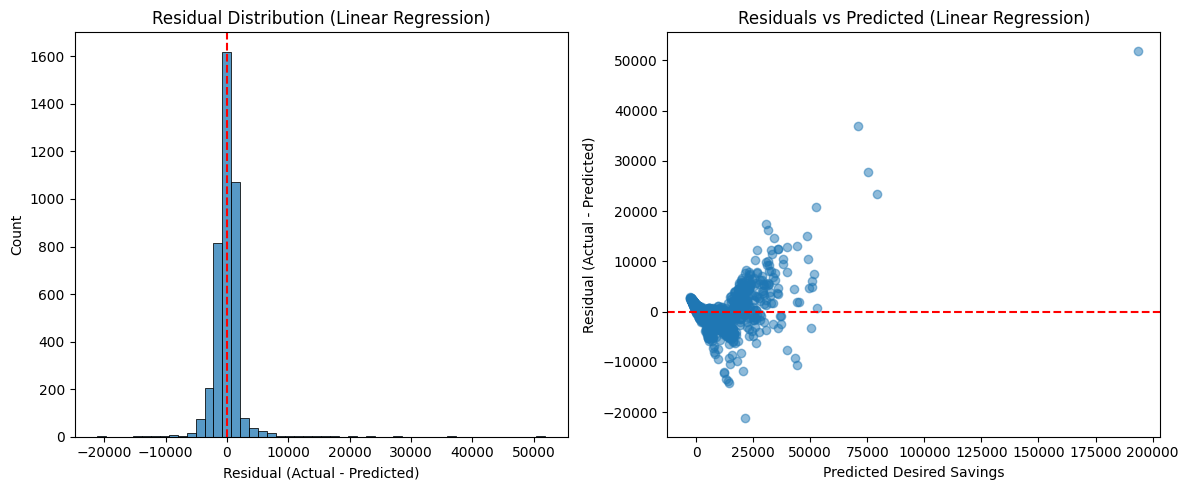

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Residuals for Linear Regression ---
lr_residuals = y_test - y_pred  # here y_pred came from lr_model.predict(X_test)

print("Residual mean:", lr_residuals.mean())
print("Residual std:", lr_residuals.std())
print("Min residual:", lr_residuals.min())
print("Max residual:", lr_residuals.max())

# Plot distribution
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(lr_residuals, bins=50, kde=False)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual Distribution (Linear Regression)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")

# Residuals vs Predicted
plt.subplot(1,2,2)
plt.scatter(y_pred, lr_residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Predicted (Linear Regression)")
plt.xlabel("Predicted Desired Savings")
plt.ylabel("Residual (Actual - Predicted)")

plt.tight_layout()
plt.show()


In [28]:
import pandas as pd

# --- Collect metrics ---
results = pd.DataFrame({
    "Model": ["Linear Regression", "XGBoost"],
    "MAE":   [1311.208594, 147.837080],   # replace with your stored values
    "RMSE":  [2314.658171, 2648.443343],  # replace with your stored values
    "R^2":   [0.925836,    0.902904]      # replace with your stored values
})

print("Model Comparison:")
print(results)

# --- Simple summary ---
best_mae_model = results.loc[results["MAE"].idxmin(), "Model"]
best_r2_model  = results.loc[results["R^2"].idxmax(), "Model"]

print("\nSummary:")
print(f"- {best_mae_model} achieved the lowest MAE (better average error).")
print(f"- {best_r2_model} achieved the highest R² (better overall fit).")
print("- Linear Regression is more interpretable.")
print("- XGBoost captures non-linear patterns but may produce bigger residuals on outliers.")


Model Comparison:
               Model          MAE         RMSE       R^2
0  Linear Regression  1311.208594  2314.658171  0.925836
1            XGBoost   147.837080  2648.443343  0.902904

Summary:
- XGBoost achieved the lowest MAE (better average error).
- Linear Regression achieved the highest R² (better overall fit).
- Linear Regression is more interpretable.
- XGBoost captures non-linear patterns but may produce bigger residuals on outliers.
